In [1]:
from sklearn.cluster import KMeans, DBSCAN
from sklearn import metrics
import matplotlib.pyplot as plt
import numpy as np
import random
import pandas
import math

# make this point to the file with the clean tweets
DATAFILE = "data_clean_stemmed_withoutRT.csv"
DATAFILE_ORIGINAL = "data_original_notStemmed_withoutRT.csv"

In [2]:
# read the csv
data = pandas.read_csv(DATAFILE, index_col=0)
data_original = pandas.read_csv(DATAFILE_ORIGINAL, index_col=0)

# NAs = data["is_retweet"].isna()
# rt_present = []
# for i in range(len(data)):
#     if NAs[i]:
#         rt_present.append('rt' in data["text"])

# # if no data is given, assume that 'rt' tells us
# # if a tweet is a retweet or not
# data["is_retweet"][data["is_retweet"].isna()] = rt_present

# # verify if all the retweets have the "rt" string
# all_have_rt = True
# # verity if all the tweets with "rt" are retweets
# all_are_retweets = True
# for i in range(len(data)):
#     if data["is_retweet"][i]:
#         all_have_rt &= "'rt'" in data["text"][i]
#     if "'rt'" in data["text"][i]:
#         all_are_retweets = all_are_retweets and data["is_retweet"][i]
# if all_have_rt:
#     print(f"All retweets have the 'rt' string")
# if all_are_retweets:
#     print(f"All 'rt' tweets are retweets")

In [3]:
# get all the tweets
# as of now, they are still strings, the string representation of the list
tweets = []
for tweet in data["text"]:
    tweets.append(eval(tweet))

# get the unique set of existing words and count those words
# check the most common ones
words = {}
total_words = 0
for tweet in tweets:
    for word in tweet:
        total_words += 1
        if word in words.keys():
            words[word] += 1
        else:
            words[word] = 1
n_tweets = data.size
print(f"We have {n_tweets} tweets")
print(f"We have {total_words} words, of which {len(words.keys())} are unique")
words_tuples = [(word, words[word]) for word in words.keys()]
words_tuples.sort(reverse=True, key=lambda t: t[1])

We have 3035 tweets
We have 53305 words, of which 4820 are unique


Text(0.5, 1.0, 'Most common tweet words')

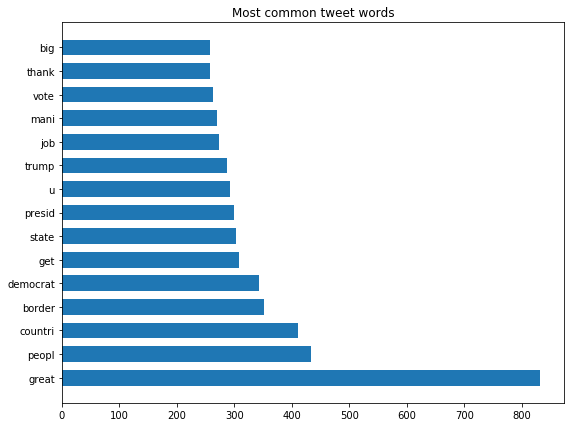

In [4]:
# plot a histogram of the N most common words
fig, ax = plt.subplots(figsize=(9,7))
N = 15
heights = [tup[1] for tup in words_tuples[:N]]
words = [tup[0] for tup in words_tuples[:N]]
indices = list(range(1, 3*N+1, 3))
bar_width = 2

ax.barh(indices, heights, bar_width)
ax.set_yticks(indices)
ax.set_yticklabels(words)
ax.set_title("Most common tweet words")

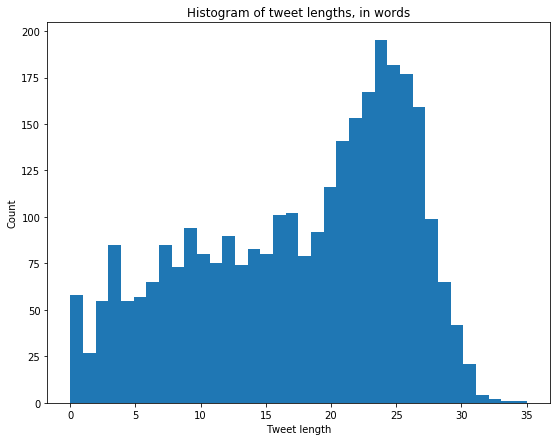

In [5]:
# plot a histogram of the number of words per tweet
lens = list(map(len, tweets))
maxsize = max(lens)

fig, ax = plt.subplots(figsize=(9,7))
ax.hist(lens, bins=maxsize+1);
ax.set_title("Histogram of tweet lengths, in words");
ax.set_xlabel("Tweet length");
ax.set_ylabel("Count");

There are 1747 words that only show up once


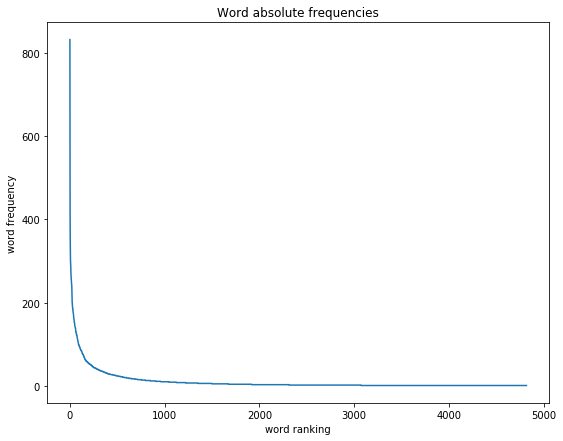

In [6]:
# check the curve of the frequencies
fig, ax = plt.subplots(figsize=(9,7))
freqs = [t[1] for t in words_tuples]
ax.plot(freqs)
ax.set_title("Word absolute frequencies")
ax.set_xlabel("word ranking")
ax.set_ylabel("word frequency")

first_one = freqs.index(1)
print(f"There are {len(freqs)-first_one} words that only show up once")

In [7]:
# check how many words make up some quantiles of the total number of words
quantiles = [0.5, 0.75, 0.9, 0.95]
# counts[i] is a pair (n, per) meaning that n words is the minimum number of
# words needed to make up for quantiles[i]% of all the words
counts = []
for q in quantiles:
    if counts:
        i = counts[-1][0]
        per = counts[-1][1]
    else:
        i = 0
        per = 0
    while per < q:
        i += 1
        per += words_tuples[i][1]/total_words
    counts.append((i, per))
for count in counts:
    print(f"{count[0]} words make up for {round(100*count[1],2)}% of all the words used")

252 words make up for 50.05% of all the words used
789 words make up for 75.01% of all the words used
1906 words make up for 90.0% of all the words used
3029 words make up for 95.0% of all the words used


['great', 'peopl', 'countri', 'border', 'democrat', 'get', 'state', 'presid', 'u', 'trump']


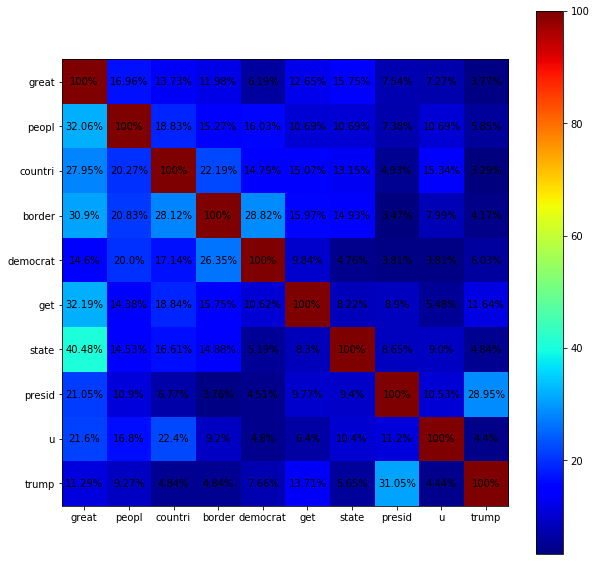

In [8]:
# take the N most common words and check how many times they show up together
N = 10
topN_words = [t[0] for t in words_tuples[:N]]
print(topN_words)
# matrix[i][j] has the percentage of tweets containing word i that also contained word j
matrix = [[0 for i in range(N)] for j in range(N)]
for j in range(N):
    base_word = topN_words[j]
    for tweet in tweets:
        if base_word in tweet:
            for i in range(j, N):
                scnd_word = topN_words[i]
                if scnd_word in tweet:
                    matrix[i][j] += 1
for j in range(N):
    for i in range(j):
        matrix[i][j] = matrix[j][i]
# at this step matrix[i][j] = matrix[j][i] only has, in (i,j), the number of times words i and j come up together
for i in range(N):
    for j in range(i+1, N):
        matrix[i][j] = round(matrix[i][j]/matrix[i][i]*100, 2)
    for j in range(i):
        matrix[i][j] = round(matrix[i][j]/matrix[i][i]*100, 2)
for i in range(N):
    matrix[i][i] = 100

# plot the matrix, code from
# https://stackoverflow.com/questions/5821125/how-to-plot-confusion-matrix-with-string-axis-rather-than-integer-in-python
fig = plt.figure(figsize=(10,10))
plt.clf()
ax = fig.add_subplot(111)
ax.set_aspect(1)
res = ax.imshow(np.array(matrix), cmap=plt.cm.jet, 
                interpolation='nearest')

width, height = N, N

for x in range(width):
    for y in range(height):
        ax.annotate(f"{matrix[x][y]}%", xy=(y, x), 
                    horizontalalignment='center',
                    verticalalignment='center')

cb = fig.colorbar(res)
plt.xticks(range(width), topN_words)
plt.yticks(range(height), topN_words)
None # prevent annoying extra output

In the above "confusion matrix" we can see, for example, that $32.39\%$ of all the tweets containing the word _people_ also contained the word _great_ (as we can confirm with the next snippet) but only $17.49\%$ of the tweets with the word _great_ contained the word _people_.

In [9]:
count = 0
hits = 0
for tweet in tweets:
    if "peopl" in tweet:
        count += 1
        if "great" in tweet:
            hits += 1
print(hits/count)

0.32061068702290074


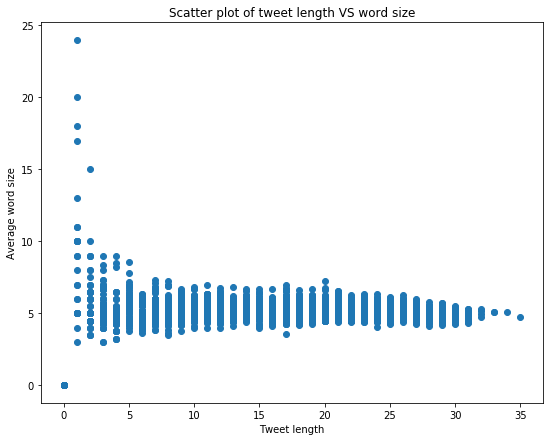

In [10]:
# check the relationship between amount of words and avg length of the words
lens = list(map(len, tweets))
avg_word_length = [sum([len(word) for word in tweets[i]])/lens[i] if lens[i] > 0 else 0 for i in range(len(lens))]

fig, ax = plt.subplots(figsize=(9,7))
ax.scatter(lens, avg_word_length)
ax.set_title("Scatter plot of tweet length VS word size");
ax.set_xlabel("Tweet length");
ax.set_ylabel("Average word size");

In [11]:
# Note that some of the tweets with only 1 long word
# actually look like they were hashtags
for tweet in tweets:
    if len(tweet) == 1 and len(tweet[0]) > 10:
        print(tweet)

['armynavygam']
['hurricaneflor']
['pledgetoamericaswork']
['memorialday']
['peaceofficersmemorialday']
['usembassyjerusalem']
['nationaldayofpray']


In [12]:
# we also got a bunch of numbers in here
# and some single letter/2-letter words that don't look good
for word, count in words_tuples:
    if len(word) < 3:
        print(word)

u
go
c
us
th
nd
p
un
g
xi
h
ms
r
j
w
ad
mr
ch
pm
ig
oh
rd
jr
ok
va
ye
ex
gp
dr
el
ag
b
ga
le
k
e
st
v
de
la
sw
n
bi
ii
bu
cd
z
lt
pa
l
iq
su
ap
al
da
ny
cb
nc
vs
lo
eu
rv
hq
cr
ty
wh
co
vy
ca
q
x
op
ed
en
aw
os
vp
ol
vi
sc
fe
rx
yr
az
md
nh
lc
ac
fl
uk
jw
dh


In [13]:
# turn each tweet into a vector with N coordinates
# also, tag each tweet with a unique ID
# coordinate i of tweeter n will say how many times the top word i appeared
N = 50
topN_words = [t[0] for t in words_tuples[:N]]
vector_tweets = []
newID = 0
for tweet in tweets:
    counts = [tweet.count(word) for word in topN_words]
    # use numpy arrays so that later calculations are easier
    vector_tweets.append((newID, np.array(counts, dtype=int)))
    newID += 1

print(topN_words)
print(len(tweets))

['great', 'peopl', 'countri', 'border', 'democrat', 'get', 'state', 'presid', 'u', 'trump', 'job', 'mani', 'vote', 'thank', 'big', 'want', 'make', 'news', 'year', 'go', 'time', 'fake', 'work', 'look', 'trade', 'america', 'total', 'much', 'american', 'good', 'crime', 'today', 'would', 'new', 'must', 'come', 'republican', 'militari', 'c', 'need', 'never', 'secur', 'deal', 'elect', 'law', 'one', 'even', 'fbi', 'senat', 'back']
3035


In [14]:
print(vector_tweets[:3])
print(vector_tweets[-3:])

[(0, array([0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0,
       0, 0, 0, 0, 0, 0])), (1, array([1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0,
       1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0,
       0, 0, 0, 0, 0, 0])), (2, array([0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0,
       0, 0, 0, 0, 0, 0]))]
[(3032, array([0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0,
       0, 0, 0, 0, 0, 0])), (3033, array([1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 1])), (3034, array([1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0,
       0, 0, 0, 1, 0, 

In [15]:
# def tweet_distance(v1, v2):
#     return np.linalg.norm(v1-v2)

C:\Users\Nerine.USMAN2\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\cluster\unsupervised.py:342: RuntimeWarning: invalid value encountered in true_divide
  score = (intra_dists[:, None] + intra_dists) / centroid_distances


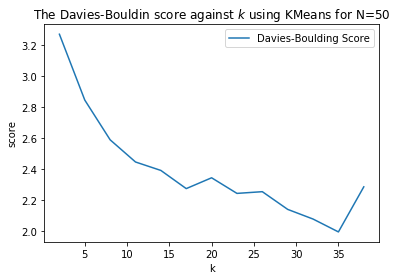

In [16]:
# Determine the Davies-Boulding Score for different values of K
K = range(2,40,3)
DB = np.zeros_like(K).astype(float)
# SilSc = np.zeros_like(K).astype(float)
i = 0

mat = np.array([t[1] for t in vector_tweets])
for k in K:
    kmeans = KMeans(n_clusters = k, random_state=73).fit(mat)
    with np.errstate(divide='ignore'):
        DB[i] = metrics.davies_bouldin_score(mat, kmeans.labels_)
#         SilSc[i] = metrics.silhouette_score(mat, kmeans.labels_, metric='euclidean')
    i += 1

plt.plot(K,DB, label = 'Davies-Boulding Score')
# plt.plot(K,SilSc, label = 'Silhouette Score')
plt.xlabel('k')
plt.ylabel('score')
plt.title(r'The Davies-Bouldin score against $k$ using KMeans for N=50')
plt.legend()
plt.show()

For small values of the DB score the algorithm performs best. For large $k$ the DB score decreases as expected. We want to take $k$ such that $k$ is small but gives a low score for DB. We will take $k = 25$.

In [17]:
# Best small k according DB score
k = 20

# use scikit to perform KMeans
kmeans = KMeans(n_clusters = k, random_state=73).fit(mat)
sk_clusters = [[] for i in range(max(kmeans.labels_+1))]
for idx, lbl in enumerate(kmeans.labels_):
    sk_clusters[lbl].append(idx)
    
# DB = davies_bouldin_score(mat, kmeans.labels_)

    
print(list(map(len, sk_clusters)))
print(mat.shape)


[86, 121, 979, 28, 292, 113, 129, 29, 136, 115, 89, 165, 34, 80, 193, 86, 66, 30, 108, 156]
(3035, 50)


In [18]:
random.seed(52345234)
# take some random tweets from every cluster
for cluster in sk_clusters:
    some_tweet_idx = random.sample(cluster, 3)
    for idx in some_tweet_idx:
        print(idx)
        print(data_original["text"][idx].replace("', '", " "))
    print("-"*40)

1179
...differences, they will be resolved in time by President Trump and China’s great President Xi Jinping. Their relationship and bond remain very strong.
718
“Trump could be the most honest president in modern history. When you look at the real barometer of presidential truthfulness, which is promise keeping, he is probably the most honest president in American history. He’s done exactly what he said he would do.” Marc Thiessen, WPost
950
“President Donald J. Trump’s Administration is Providing Support to Those Impacted by Hurricane Florence” https://t.co/3neafSgQ1h
----------------------------------------
1335
“Very concerned about Comey’s firing, afraid they will be exposed,” said Bruce Ohr. DOJ’s Emails &amp; Notes show Bruce Ohr’s connection to (phony &amp; discredited) Trump Dossier. A creep thinking he would get caught in a dishonest act. Rigged Witch Hunt!
1490
Congratulations to  @GreggJarrett on The TREMENDOUS success of his just out book, “The Russia Hoax, The Illicit Sch

1: We have 1617 words, of which 742 are unique
2: We have 2502 words, of which 1012 are unique
3: We have 12481 words, of which 2803 are unique
4: We have 709 words, of which 307 are unique
5: We have 4791 words, of which 1541 are unique
6: We have 2157 words, of which 970 are unique
7: We have 2335 words, of which 986 are unique
8: We have 717 words, of which 284 are unique
9: We have 2720 words, of which 1052 are unique
10: We have 2203 words, of which 900 are unique
11: We have 1603 words, of which 624 are unique
12: We have 3626 words, of which 1081 are unique
13: We have 742 words, of which 360 are unique
14: We have 1688 words, of which 607 are unique
15: We have 4115 words, of which 1445 are unique
16: We have 2031 words, of which 534 are unique
17: We have 1521 words, of which 568 are unique
18: We have 709 words, of which 299 are unique
19: We have 1974 words, of which 819 are unique
20: We have 3064 words, of which 1018 are unique


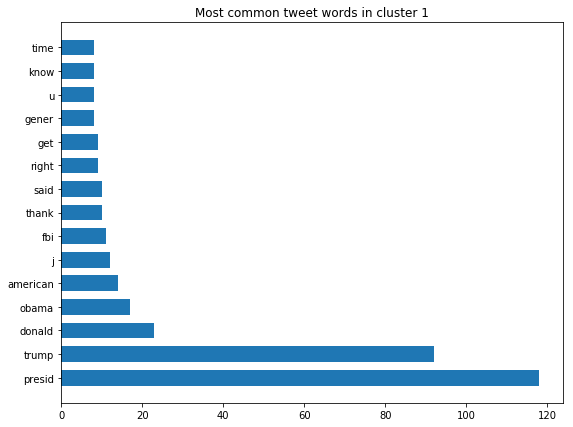

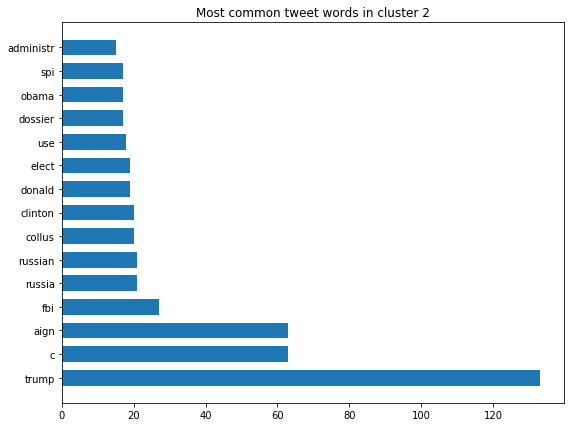

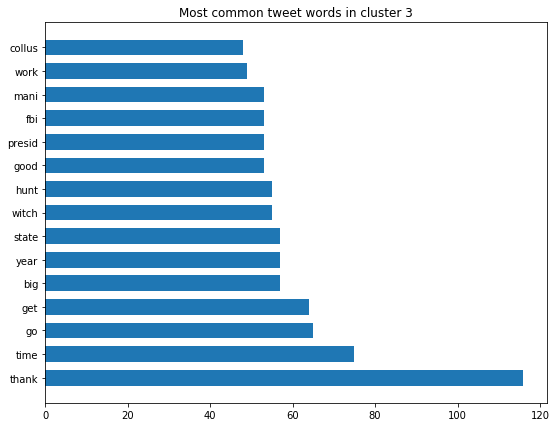

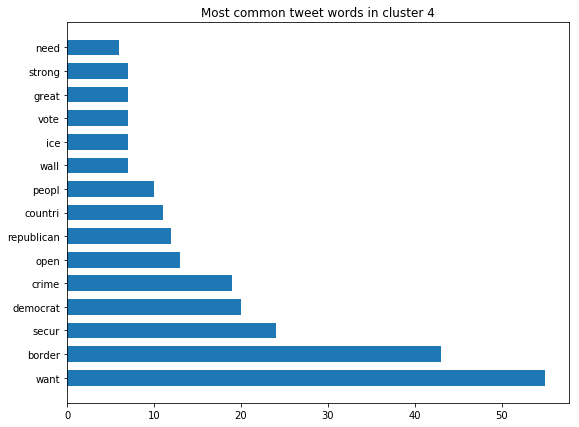

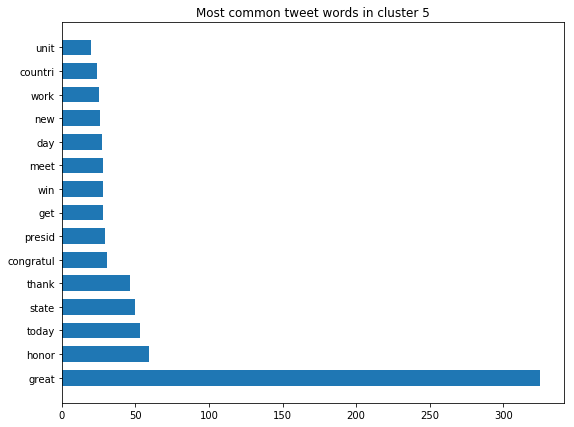

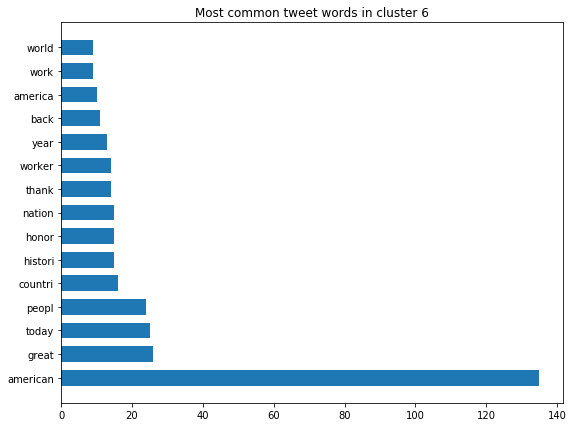

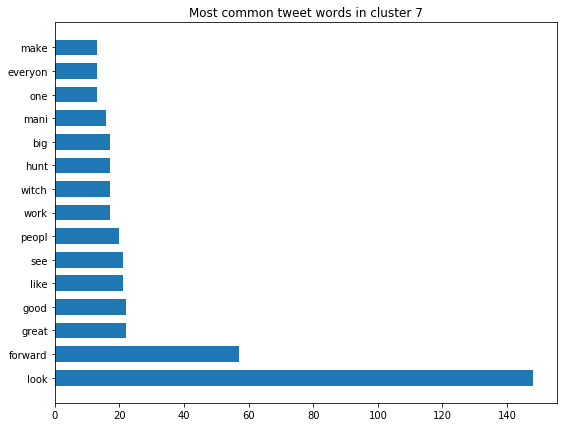

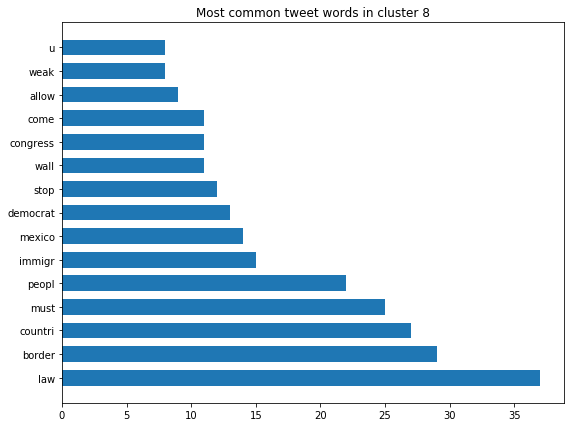

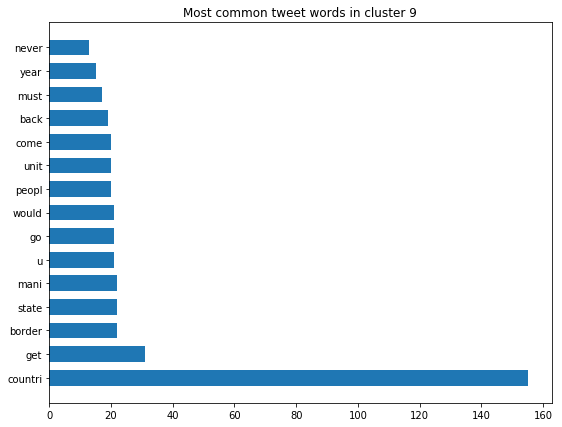

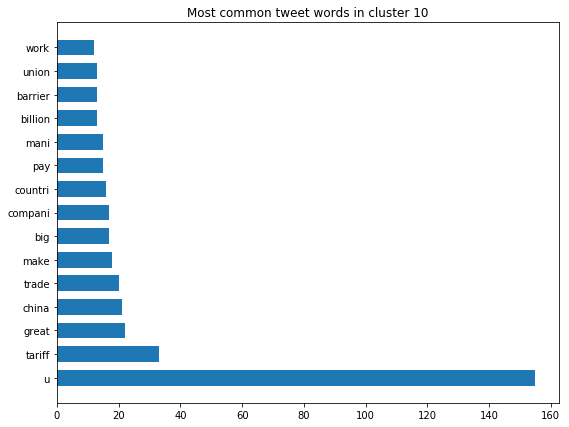

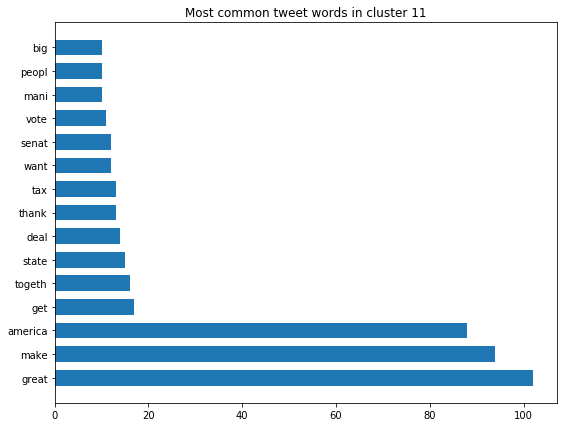

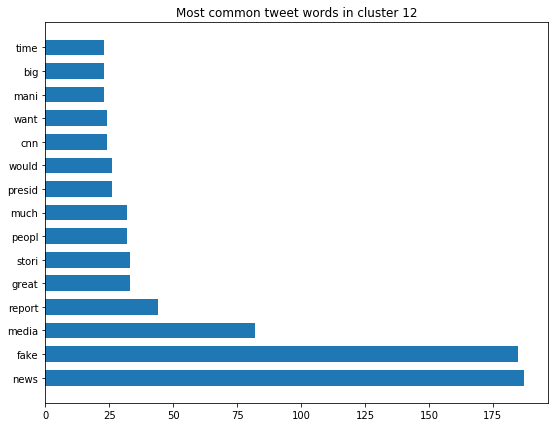

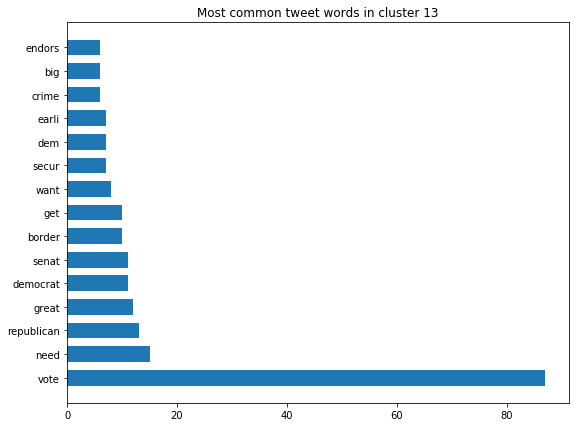

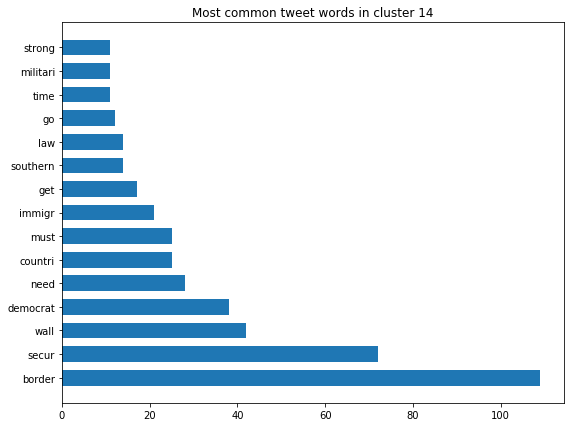

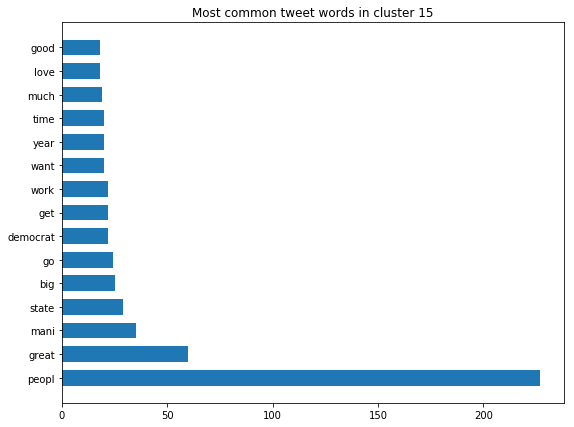

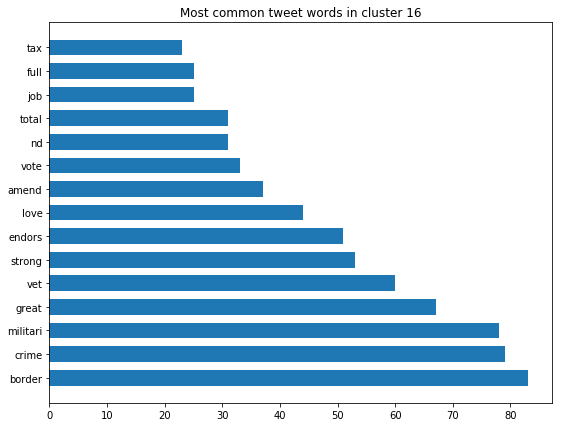

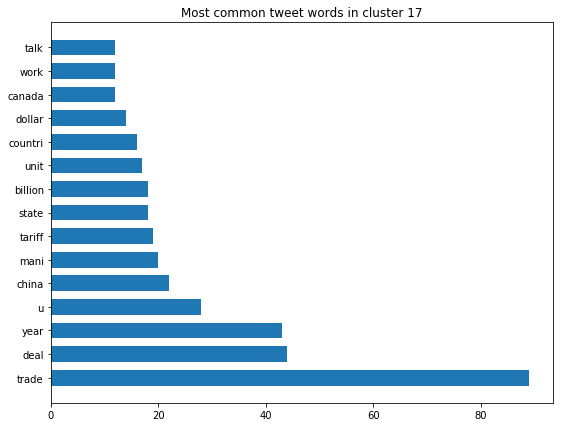

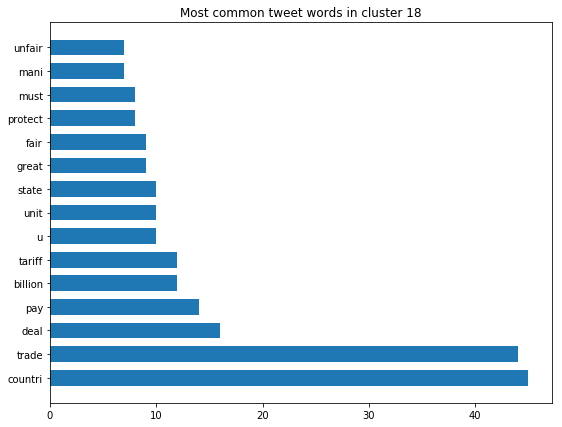

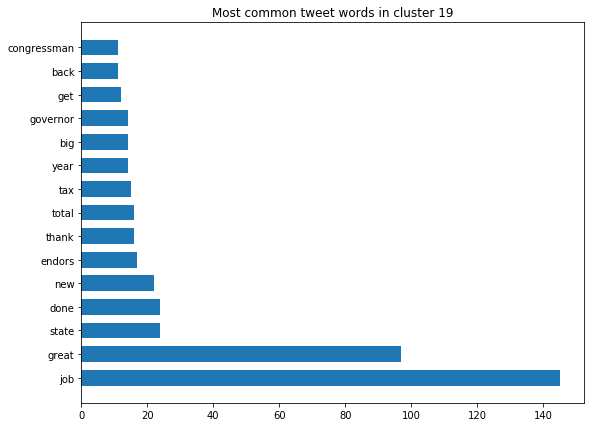

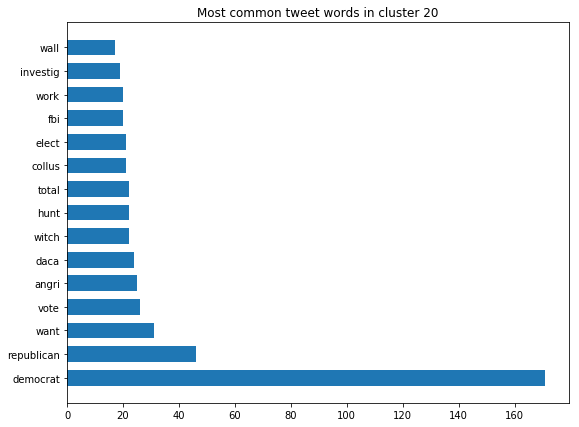

In [19]:
## Visualize different clusters

nr_cluster = 1
for cluster in sk_clusters:
    nr_cluster += 1
    tweets_c = []
    for tweet in data["text"][cluster]:
        tweets_c.append(eval(tweet))

    # get the unique set of existing words and count those words
    # check the most common ones
    words = {}
    total_words = 0
    for tweet in tweets_c:
        for word in tweet:
            total_words += 1
            if word in words.keys():
                words[word] += 1
            else:
                words[word] = 1
    print(str(nr_cluster-1)+f": We have {total_words} words, of which {len(words.keys())} are unique")
    words_tuples = [(word, words[word]) for word in words.keys()]
    words_tuples.sort(reverse=True, key=lambda t: t[1])
    # plot a histogram of the N most common words
    fig, ax = plt.subplots(figsize=(9,7))
    M = 15
    heights = [tup[1] for tup in words_tuples[:M]]
    words = [tup[0] for tup in words_tuples[:M]]
    indices = list(range(1, 3*M+1, 3))
    bar_width = 2

    ax.barh(indices, heights, bar_width)
    ax.set_yticks(indices)
    ax.set_yticklabels(words)
    ax.set_title("Most common tweet words in cluster "+str(nr_cluster-1))



# DBSCAN

Using eps = 0.2 , got 40 clusters


C:\Users\Nerine.USMAN2\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\cluster\unsupervised.py:342: RuntimeWarning: invalid value encountered in true_divide
  score = (intra_dists[:, None] + intra_dists) / centroid_distances


Using eps = 0.24482758620689657 , got 40 clusters


C:\Users\Nerine.USMAN2\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\cluster\unsupervised.py:342: RuntimeWarning: invalid value encountered in true_divide
  score = (intra_dists[:, None] + intra_dists) / centroid_distances


Using eps = 0.2896551724137931 , got 40 clusters


C:\Users\Nerine.USMAN2\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\cluster\unsupervised.py:342: RuntimeWarning: invalid value encountered in true_divide
  score = (intra_dists[:, None] + intra_dists) / centroid_distances


Using eps = 0.33448275862068966 , got 40 clusters


C:\Users\Nerine.USMAN2\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\cluster\unsupervised.py:342: RuntimeWarning: invalid value encountered in true_divide
  score = (intra_dists[:, None] + intra_dists) / centroid_distances


Using eps = 0.3793103448275862 , got 40 clusters


C:\Users\Nerine.USMAN2\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\cluster\unsupervised.py:342: RuntimeWarning: invalid value encountered in true_divide
  score = (intra_dists[:, None] + intra_dists) / centroid_distances


Using eps = 0.4241379310344828 , got 40 clusters


C:\Users\Nerine.USMAN2\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\cluster\unsupervised.py:342: RuntimeWarning: invalid value encountered in true_divide
  score = (intra_dists[:, None] + intra_dists) / centroid_distances


Using eps = 0.4689655172413793 , got 40 clusters


C:\Users\Nerine.USMAN2\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\cluster\unsupervised.py:342: RuntimeWarning: invalid value encountered in true_divide
  score = (intra_dists[:, None] + intra_dists) / centroid_distances


Using eps = 0.5137931034482759 , got 40 clusters


C:\Users\Nerine.USMAN2\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\cluster\unsupervised.py:342: RuntimeWarning: invalid value encountered in true_divide
  score = (intra_dists[:, None] + intra_dists) / centroid_distances


Using eps = 0.5586206896551724 , got 40 clusters


C:\Users\Nerine.USMAN2\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\cluster\unsupervised.py:342: RuntimeWarning: invalid value encountered in true_divide
  score = (intra_dists[:, None] + intra_dists) / centroid_distances


Using eps = 0.603448275862069 , got 40 clusters


C:\Users\Nerine.USMAN2\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\cluster\unsupervised.py:342: RuntimeWarning: invalid value encountered in true_divide
  score = (intra_dists[:, None] + intra_dists) / centroid_distances


Using eps = 0.6482758620689655 , got 40 clusters


C:\Users\Nerine.USMAN2\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\cluster\unsupervised.py:342: RuntimeWarning: invalid value encountered in true_divide
  score = (intra_dists[:, None] + intra_dists) / centroid_distances


Using eps = 0.693103448275862 , got 40 clusters


C:\Users\Nerine.USMAN2\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\cluster\unsupervised.py:342: RuntimeWarning: invalid value encountered in true_divide
  score = (intra_dists[:, None] + intra_dists) / centroid_distances


Using eps = 0.7379310344827585 , got 40 clusters


C:\Users\Nerine.USMAN2\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\cluster\unsupervised.py:342: RuntimeWarning: invalid value encountered in true_divide
  score = (intra_dists[:, None] + intra_dists) / centroid_distances


Using eps = 0.7827586206896551 , got 40 clusters


C:\Users\Nerine.USMAN2\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\cluster\unsupervised.py:342: RuntimeWarning: invalid value encountered in true_divide
  score = (intra_dists[:, None] + intra_dists) / centroid_distances


Using eps = 0.8275862068965518 , got 40 clusters


C:\Users\Nerine.USMAN2\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\cluster\unsupervised.py:342: RuntimeWarning: invalid value encountered in true_divide
  score = (intra_dists[:, None] + intra_dists) / centroid_distances


Using eps = 0.8724137931034484 , got 40 clusters


C:\Users\Nerine.USMAN2\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\cluster\unsupervised.py:342: RuntimeWarning: invalid value encountered in true_divide
  score = (intra_dists[:, None] + intra_dists) / centroid_distances


Using eps = 0.9172413793103449 , got 40 clusters


C:\Users\Nerine.USMAN2\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\cluster\unsupervised.py:342: RuntimeWarning: invalid value encountered in true_divide
  score = (intra_dists[:, None] + intra_dists) / centroid_distances


Using eps = 0.9620689655172414 , got 40 clusters


C:\Users\Nerine.USMAN2\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\cluster\unsupervised.py:342: RuntimeWarning: invalid value encountered in true_divide
  score = (intra_dists[:, None] + intra_dists) / centroid_distances


Using eps = 1.006896551724138 , got 3 clusters
Using eps = 1.0517241379310345 , got 3 clusters
Using eps = 1.096551724137931 , got 3 clusters
Using eps = 1.1413793103448275 , got 3 clusters
Using eps = 1.186206896551724 , got 3 clusters
Using eps = 1.2310344827586206 , got 3 clusters
Using eps = 1.2758620689655171 , got 3 clusters
Using eps = 1.3206896551724137 , got 3 clusters
Using eps = 1.3655172413793102 , got 3 clusters
Using eps = 1.410344827586207 , got 3 clusters
Using eps = 1.4551724137931035 , got 2 clusters
Using eps = 1.5 , got 2 clusters


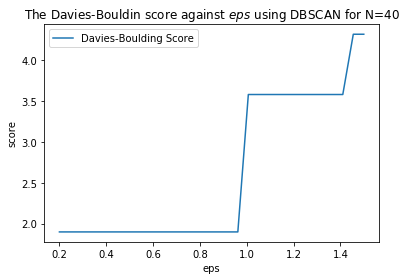

In [20]:
# apply the DBSCAN algorithm for different values of eps (=the the maximal distance for points to be neighbours)
Eps = np.linspace(.2,1.5,30)
DB = np.zeros_like(Eps).astype(float)
i = 0
mat = np.array([t[1] for t in vector_tweets])
n_clusters = []
for eps in Eps:
    dbscan = DBSCAN(eps = eps).fit(mat)
    dbscan_clusters = [[] for i in range(max(dbscan.labels_+1))]
    for idx, lbl in enumerate(dbscan.labels_):
        dbscan_clusters[lbl].append(idx)
    print(f"Using eps = {eps} , got {len(dbscan_clusters)} clusters")
    n_clusters.append(len(dbscan_clusters))
    with np.errstate(divide='ignore'):
        DB[i] = metrics.davies_bouldin_score(mat, dbscan.labels_)
    i += 1
    

plt.plot(Eps, DB, label = 'Davies-Boulding Score')
# plt.plot(K,SilSc, label = 'Silhouette Score')
plt.xlabel('eps')
plt.ylabel('score')
plt.title(r'The Davies-Bouldin score against $eps$ using DBSCAN for N=40')
plt.legend()
plt.show()




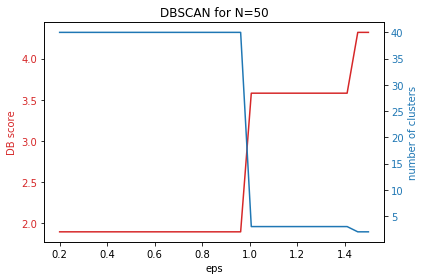

In [21]:
## Plot results of DBSCAN for different valus of eps
fig, ax1 = plt.subplots()

color = 'tab:red'
ax1.set_xlabel('eps')
ax1.set_ylabel('DB score', color=color)
ax1.plot(Eps, DB, color=color)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = 'tab:blue'
ax2.set_ylabel('number of clusters', color=color)  # we already handled the x-label with ax1
ax2.plot(Eps, n_clusters, color=color)
ax2.tick_params(axis='y', labelcolor=color)
plt.title(f'DBSCAN for N={N}')

fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.show()

In [22]:
# Best epsilon according DB score
eps_opt = .8 ## ???

# Perform final DBSCAN fit
dbscan = DBSCAN(eps = eps_opt).fit(mat)
dbscan_clusters = [[] for i in range(max(dbscan.labels_+1))]
for idx, lbl in enumerate(dbscan.labels_):
    dbscan_clusters[lbl].append(idx)
DB = metrics.davies_bouldin_score(mat, dbscan.labels_)

    
print(list(map(len, dbscan_clusters)))
print(f'Davies-Boulding score = {DB}')


[9, 6, 16, 277, 17, 39, 12, 7, 13, 5, 7, 15, 6, 10, 20, 12, 10, 8, 7, 7, 13, 6, 7, 13, 5, 7, 56, 10, 6, 6, 5, 14, 6, 5, 6, 10, 12, 6, 6, 2333]
Davies-Boulding score = 1.8979337337730462


C:\Users\Nerine.USMAN2\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\cluster\unsupervised.py:342: RuntimeWarning: divide by zero encountered in true_divide
  score = (intra_dists[:, None] + intra_dists) / centroid_distances
C:\Users\Nerine.USMAN2\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\cluster\unsupervised.py:342: RuntimeWarning: invalid value encountered in true_divide
  score = (intra_dists[:, None] + intra_dists) / centroid_distances


In [23]:
random.seed(52345234)
# take some random tweets from every cluster
for cluster in dbscan_clusters:
    some_tweet_idx = random.sample(cluster, 3)
    for idx in some_tweet_idx:
        print(idx)
        print(data_original["text"][idx].replace("', '", " "))
    print("-"*40)

842
Thank you Governor Phil Bryant - it was my great honor to be there! #MAGA https://t.co/UbY7Qu2fMt
597
It was my great honor, thank you! https://t.co/U2Nt1hpaVv
2260
Thank you to the Washington Examiner and @CortesSteve on the great article - on WINNING! https://t.co/b5dfUABN5q
----------------------------------------
205
It is being reported that Leakin' James Comey was told by Department of Justice attorneys not to answer the most important questions. Total bias and corruption at the highest levels of previous Administration. Force him to answer the questions under oath!
552
....Richard Cordray will let you down, just like he did when he destroyed the government agency that he ran. Clone of Pocahontas, that’s not for Ohio. Mike has my Total Endorsement!
2516
A TOTAL WITCH HUNT!!!
----------------------------------------
2473
Russia and China are playing the Currency Devaluation game as the U.S. keeps raising interest rates. Not acceptable!
1997
The fact that I am having a meeting 

1: We have 101 words, of which 80 are unique
2: We have 56 words, of which 46 are unique
3: We have 160 words, of which 125 are unique
4: We have 1625 words, of which 882 are unique
5: We have 126 words, of which 92 are unique
6: We have 361 words, of which 252 are unique
7: We have 122 words, of which 102 are unique
8: We have 94 words, of which 80 are unique
9: We have 136 words, of which 90 are unique
10: We have 81 words, of which 76 are unique
11: We have 106 words, of which 96 are unique
12: We have 156 words, of which 110 are unique
13: We have 114 words, of which 101 are unique
14: We have 101 words, of which 84 are unique
15: We have 324 words, of which 196 are unique
16: We have 114 words, of which 81 are unique
17: We have 115 words, of which 80 are unique
18: We have 63 words, of which 52 are unique
19: We have 93 words, of which 82 are unique
20: We have 71 words, of which 58 are unique
21: We have 138 words, of which 95 are unique
22: We have 80 words, of which 66 are uni

C:\Users\Nerine.USMAN2\AppData\Local\Continuum\anaconda3\lib\site-packages\matplotlib\pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


23: We have 129 words, of which 88 are unique
24: We have 71 words, of which 29 are unique
25: We have 83 words, of which 69 are unique
26: We have 92 words, of which 73 are unique
27: We have 246 words, of which 146 are unique
28: We have 74 words, of which 54 are unique
29: We have 100 words, of which 87 are unique
30: We have 68 words, of which 54 are unique
31: We have 39 words, of which 32 are unique
32: We have 121 words, of which 97 are unique
33: We have 125 words, of which 95 are unique
34: We have 66 words, of which 56 are unique
35: We have 53 words, of which 29 are unique
36: We have 152 words, of which 122 are unique
37: We have 155 words, of which 121 are unique
38: We have 66 words, of which 58 are unique
39: We have 99 words, of which 65 are unique
40: We have 47229 words, of which 4440 are unique


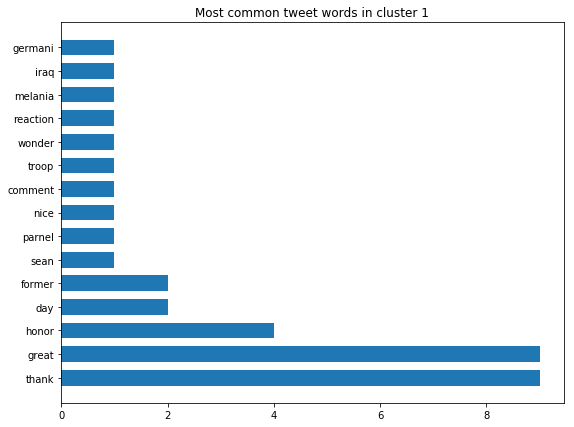

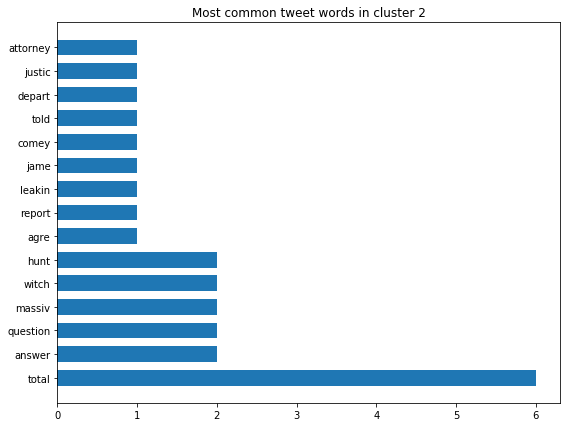

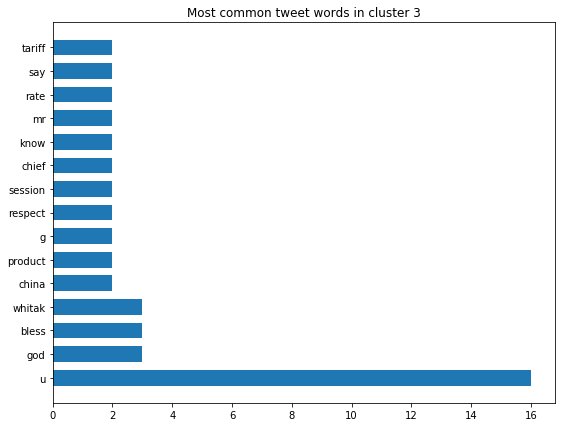

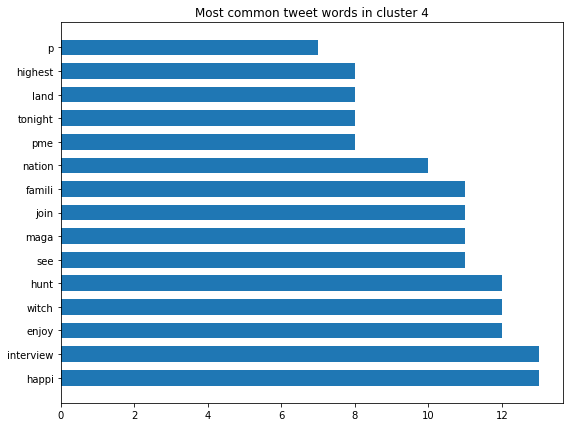

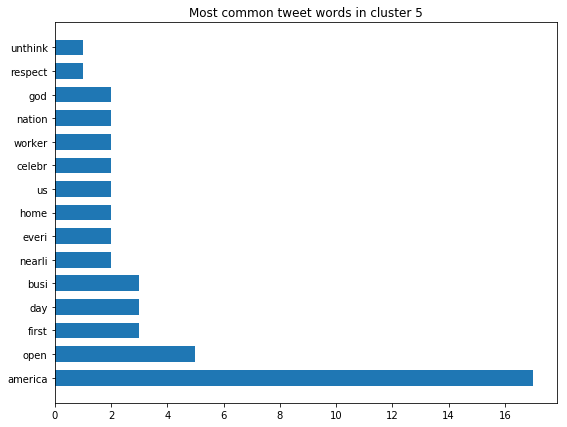

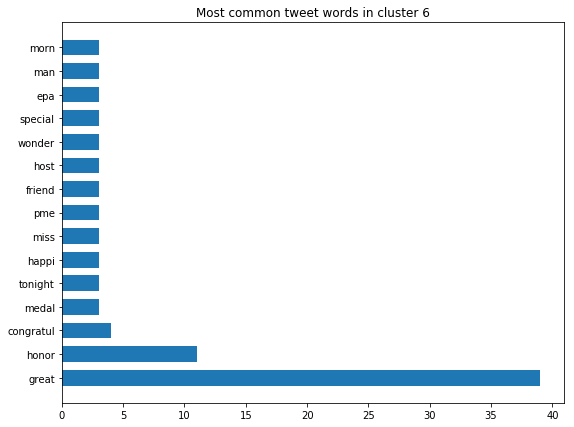

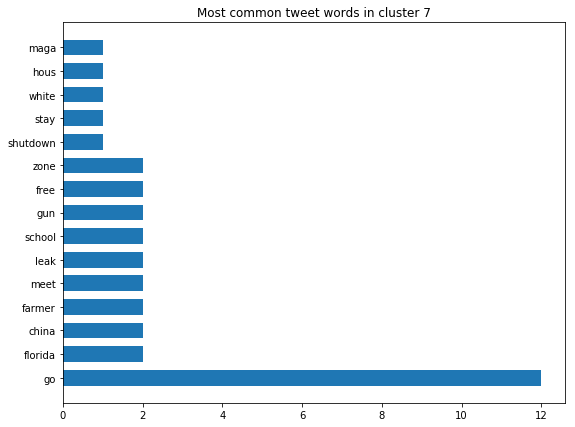

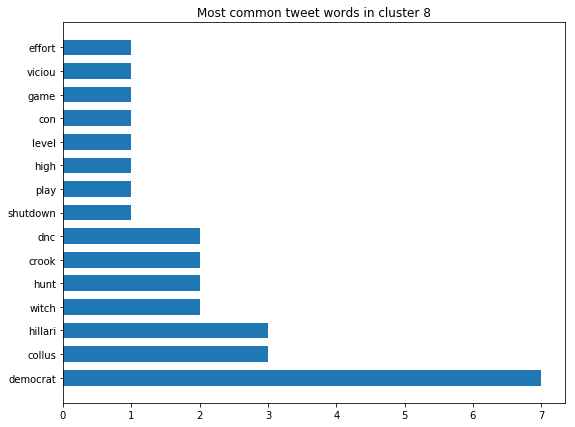

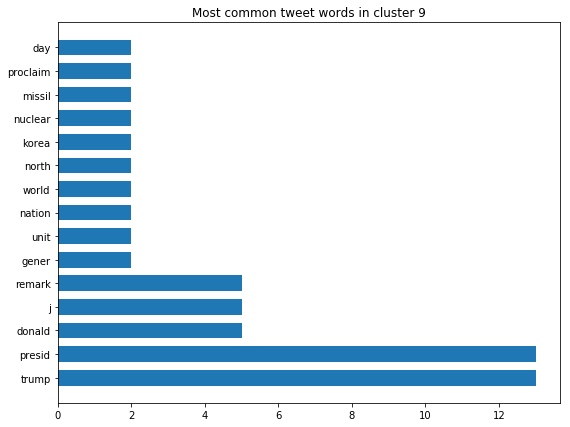

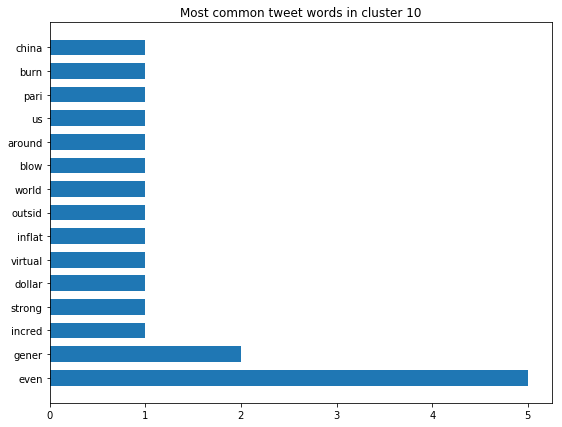

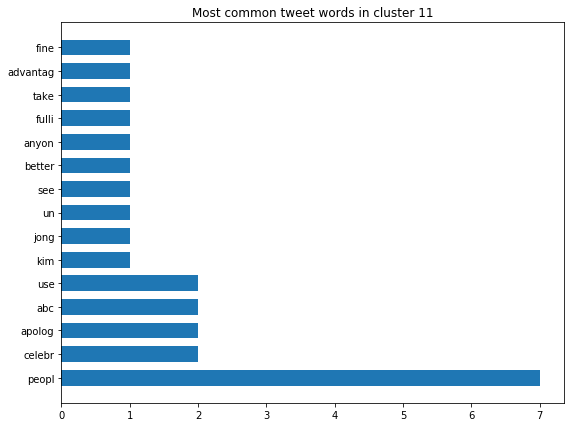

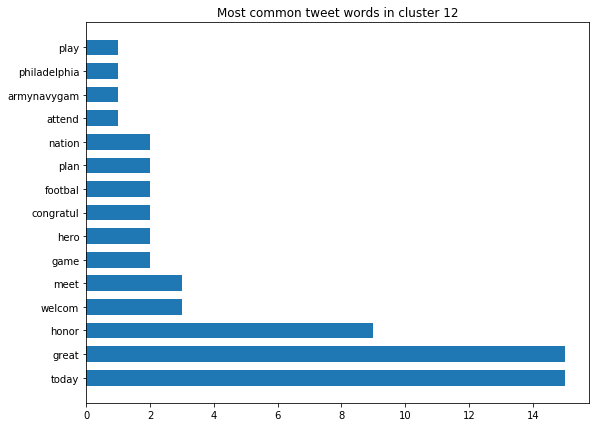

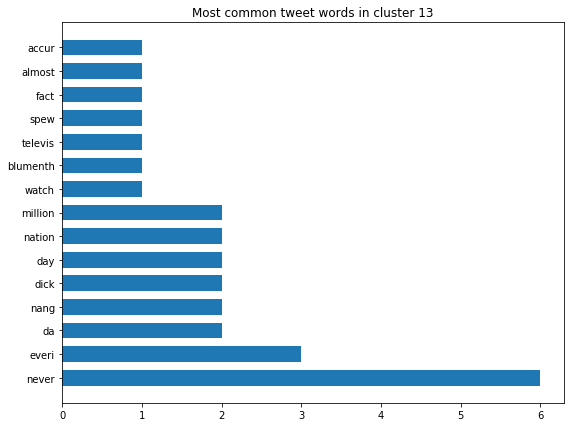

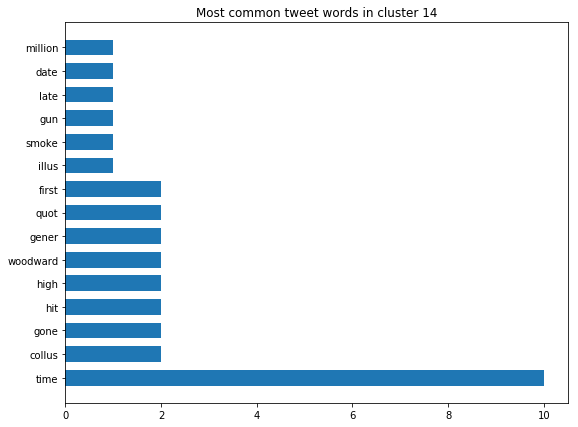

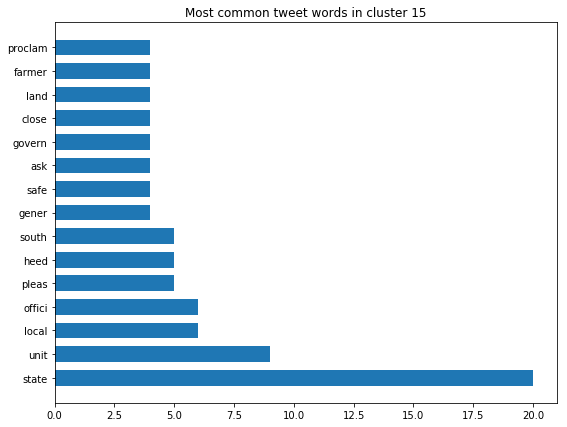

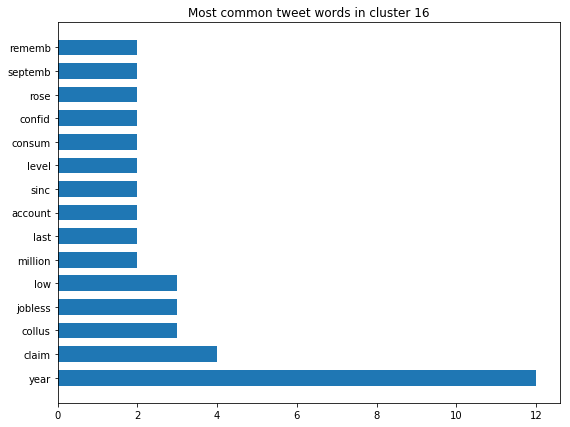

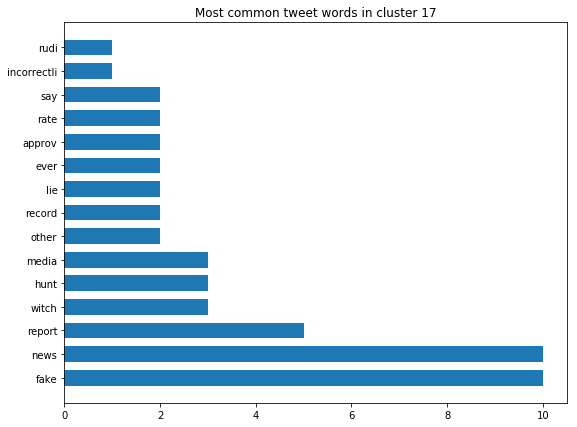

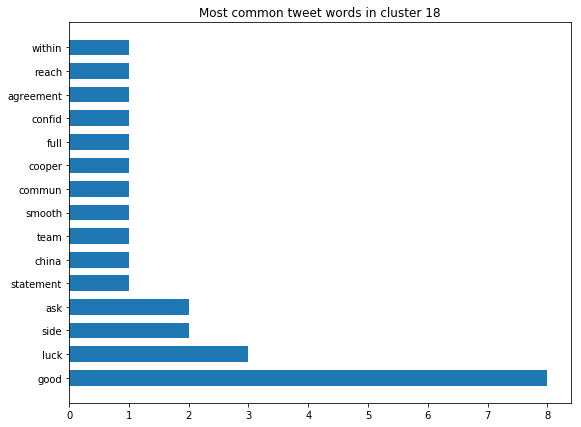

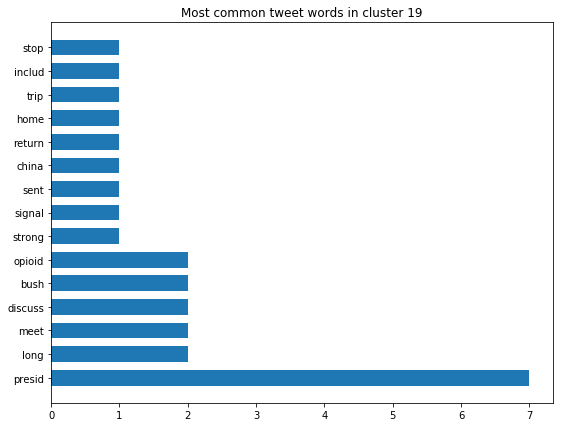

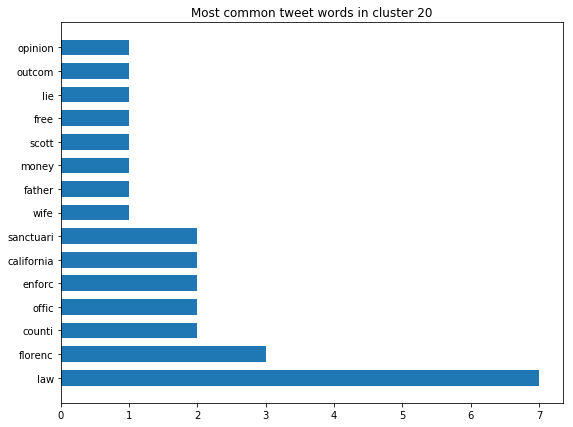

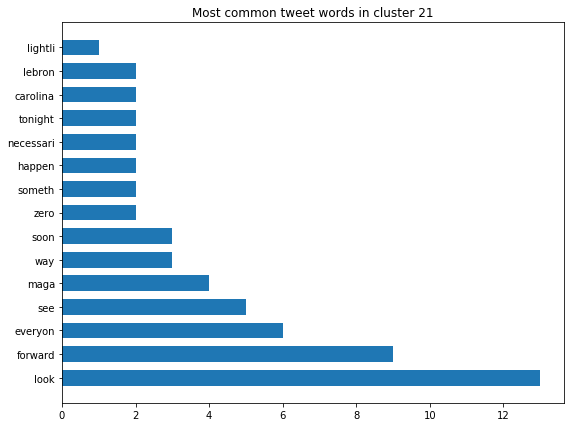

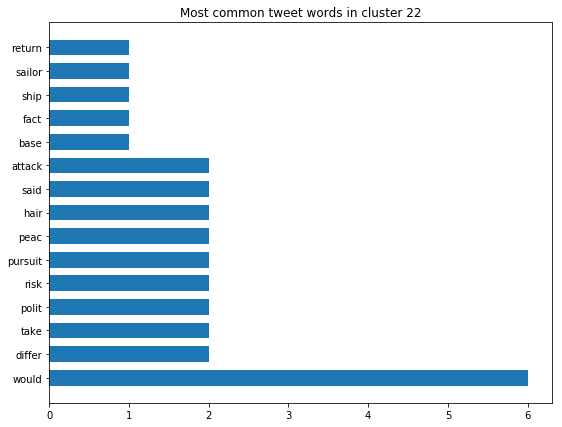

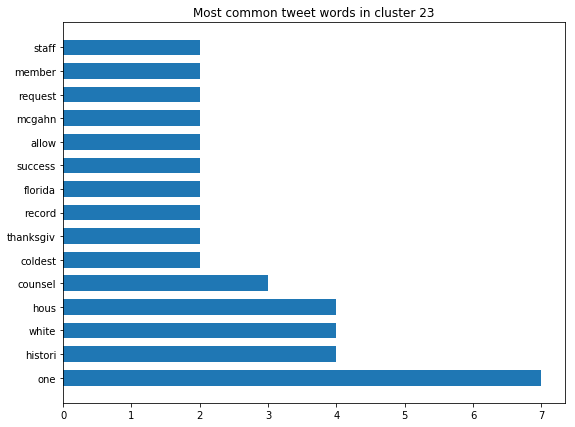

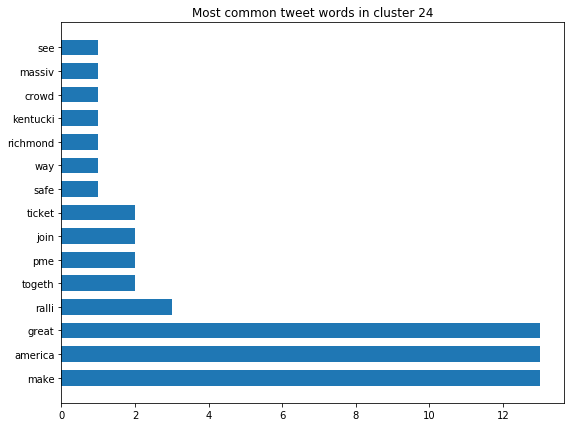

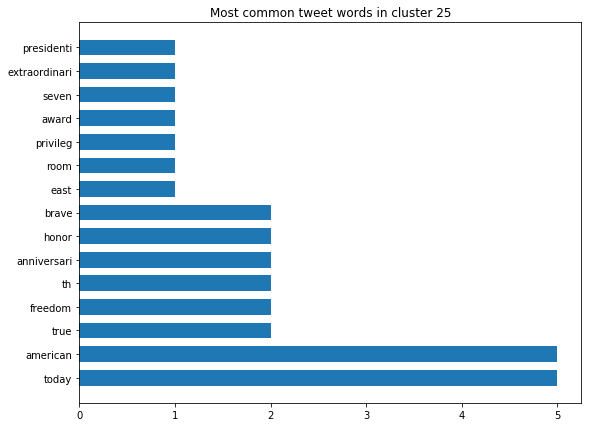

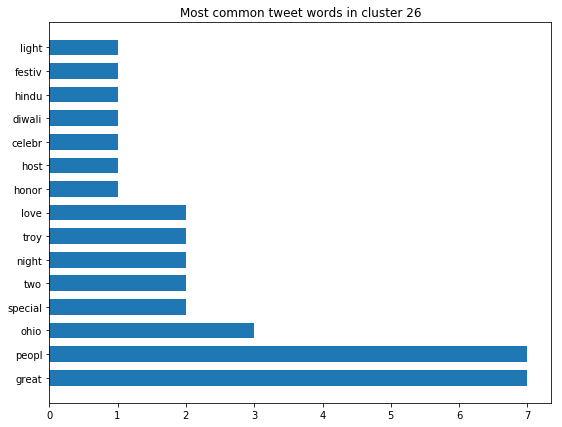

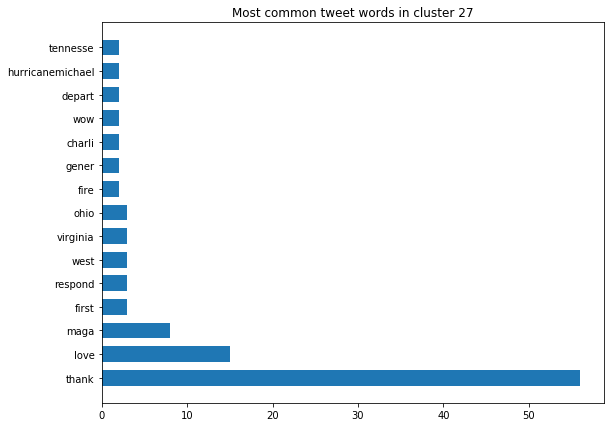

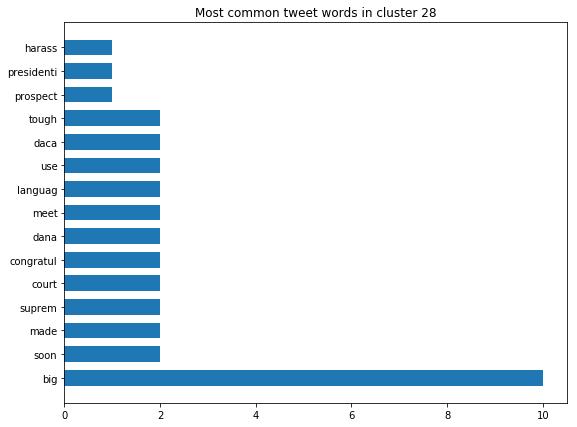

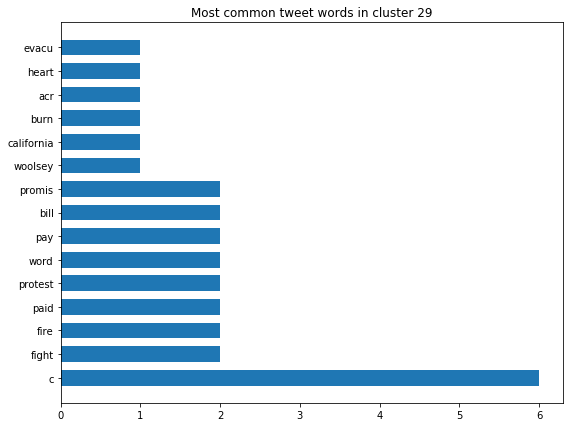

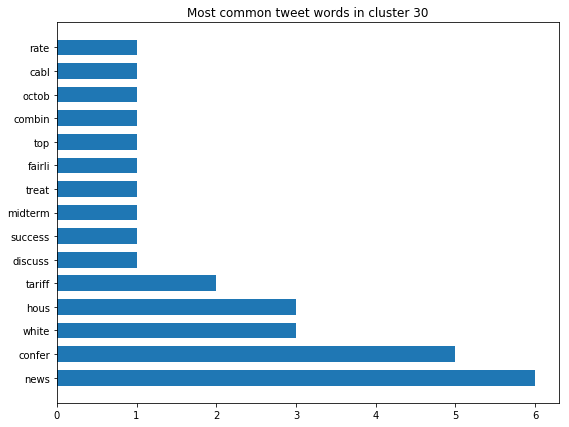

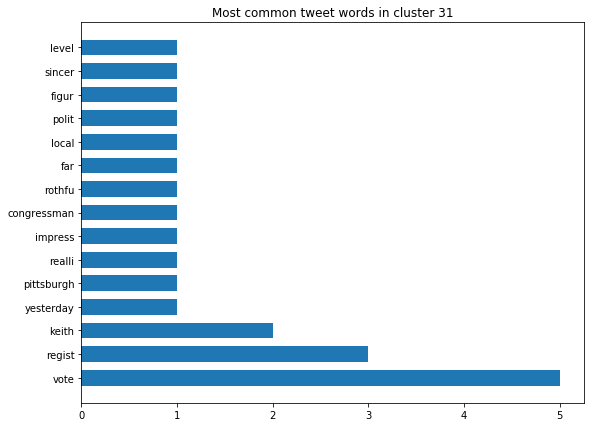

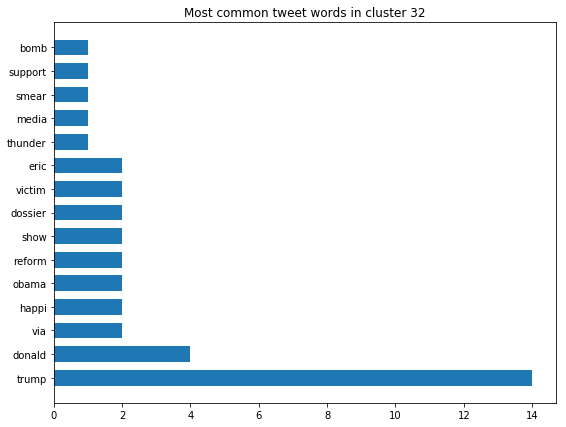

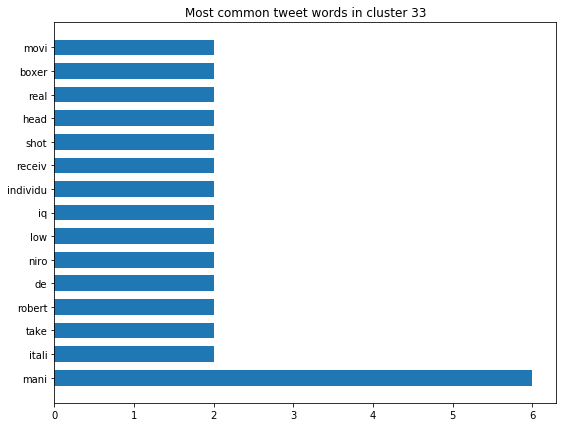

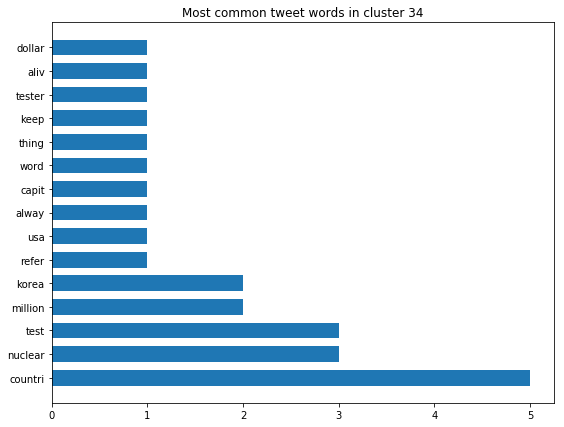

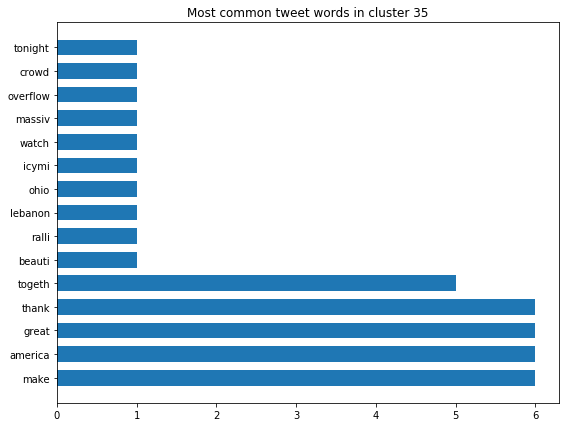

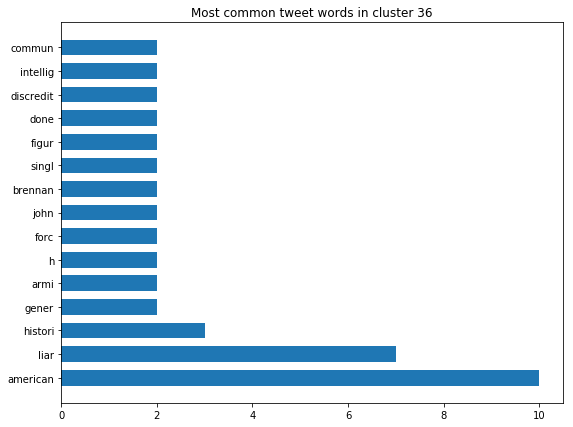

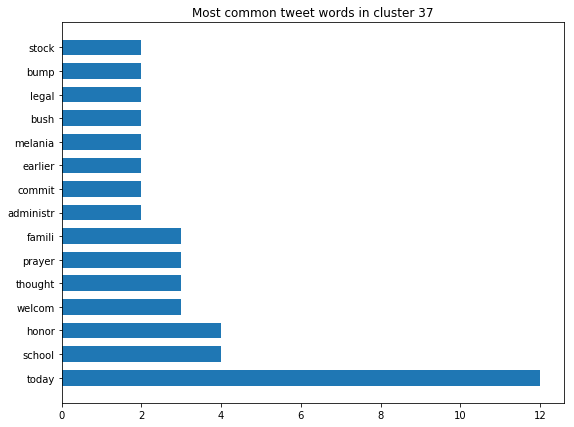

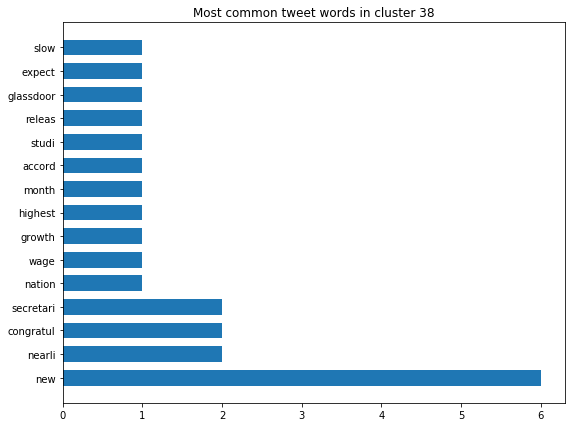

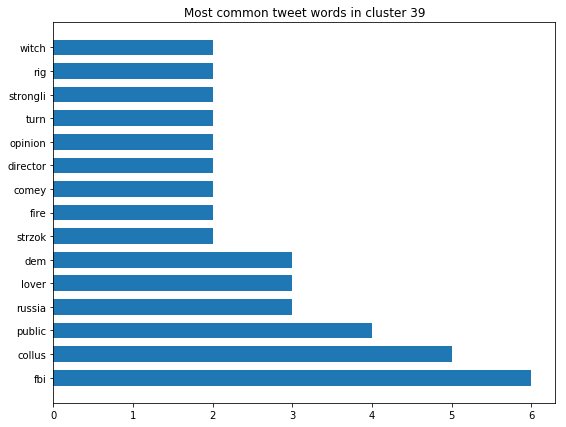

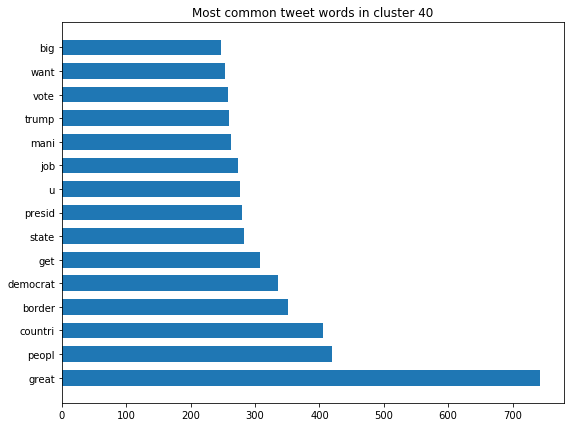

In [24]:
## Visualize different clusters

nr_cluster = 1
for cluster in dbscan_clusters:
    nr_cluster += 1
    tweets = []
    for tweet in data["text"][cluster]:
        tweets.append(eval(tweet))

    # get the unique set of existing words and count those words
    # check the most common ones
    words = {}
    total_words = 0
    for tweet in tweets:
        for word in tweet:
            total_words += 1
            if word in words.keys():
                words[word] += 1
            else:
                words[word] = 1
    print(str(nr_cluster-1)+f": We have {total_words} words, of which {len(words.keys())} are unique")
    words_tuples = [(word, words[word]) for word in words.keys()]
    words_tuples.sort(reverse=True, key=lambda t: t[1])
    # plot a histogram of the N most common words
    fig, ax = plt.subplots(figsize=(9,7))
    N = 15
    heights = [tup[1] for tup in words_tuples[:N]]
    words = [tup[0] for tup in words_tuples[:N]]
    indices = list(range(1, 3*N+1, 3))
    bar_width = 2

    ax.barh(indices, heights, bar_width)
    ax.set_yticks(indices)
    ax.set_yticklabels(words)
    ax.set_title("Most common tweet words in cluster "+str(nr_cluster-1))

